In [2]:
! pip install autots

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 843.3/843.3 kB 5.9 MB/s eta 0:00:00


In [3]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from statsmodels.tsa.stattools import adfuller
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.forecasting.theta import ThetaModel
from numpy.linalg import LinAlgError

from prophet import Prophet
from prophet.diagnostics import cross_validation
from math import sqrt
from prophet.plot import add_changepoints_to_plot
import sklearn.metrics as skmetrics #For evaluation metrics

from autots import AutoTS, model_forecast

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Data Loading and Overview

In [4]:
# Reading in the data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/Steel_industry_data.csv', parse_dates=True) # change to you directory
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')

# Getting the day of each date
df['day'] = pd.to_datetime(df['date']).dt.date

In [5]:
# Categorically Encode the Categorical Variables
df_encoded = pd.get_dummies(df, columns=['WeekStatus', 'Day_of_week', 'Load_Type'], dtype='int')

# Calculate the maximum of numerical columns after grouping by 'day'
dfnew_max = df_encoded.drop(['date'], axis=1).groupby(['day']).max(numeric_only=True)
dfnew_max.reset_index(inplace=True)
dfnew_max.set_index('day', inplace=True)

In [6]:
dfnew_max

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus_Weekday,WeekStatus_Weekend,Day_of_week_Friday,Day_of_week_Monday,Day_of_week_Saturday,Day_of_week_Sunday,Day_of_week_Thursday,Day_of_week_Tuesday,Day_of_week_Wednesday,Load_Type_Light_Load,Load_Type_Maximum_Load,Load_Type_Medium_Load
day,,,,,,,,,,,,,,,,,,,
2018-01-01,4.28,5.00,25.20,0.00,100.0,100.0,85500,1,0,0,1,0,0,0,0,0,1,0,0
2018-01-02,147.46,78.48,26.50,0.00,100.0,100.0,85500,1,0,0,0,0,0,0,1,0,1,1,1
2018-01-03,140.51,53.32,26.82,0.06,100.0,100.0,85500,1,0,0,0,0,0,0,0,1,1,1,1
2018-01-04,144.29,75.82,26.89,0.07,100.0,100.0,85500,1,0,0,0,0,0,1,0,0,1,1,1
2018-01-05,146.34,66.92,26.68,0.07,100.0,100.0,85500,1,0,1,0,0,0,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,76.03,51.77,22.43,0.03,100.0,100.0,85500,1,0,0,0,0,0,1,0,0,1,1,1
2018-12-28,66.82,40.86,22.68,0.03,100.0,100.0,85500,1,0,1,0,0,0,0,0,0,1,1,1
2018-12-29,26.17,3.53,21.17,0.01,100.0,100.0,85500,0,1,0,0,1,0,0,0,0,1,0,0


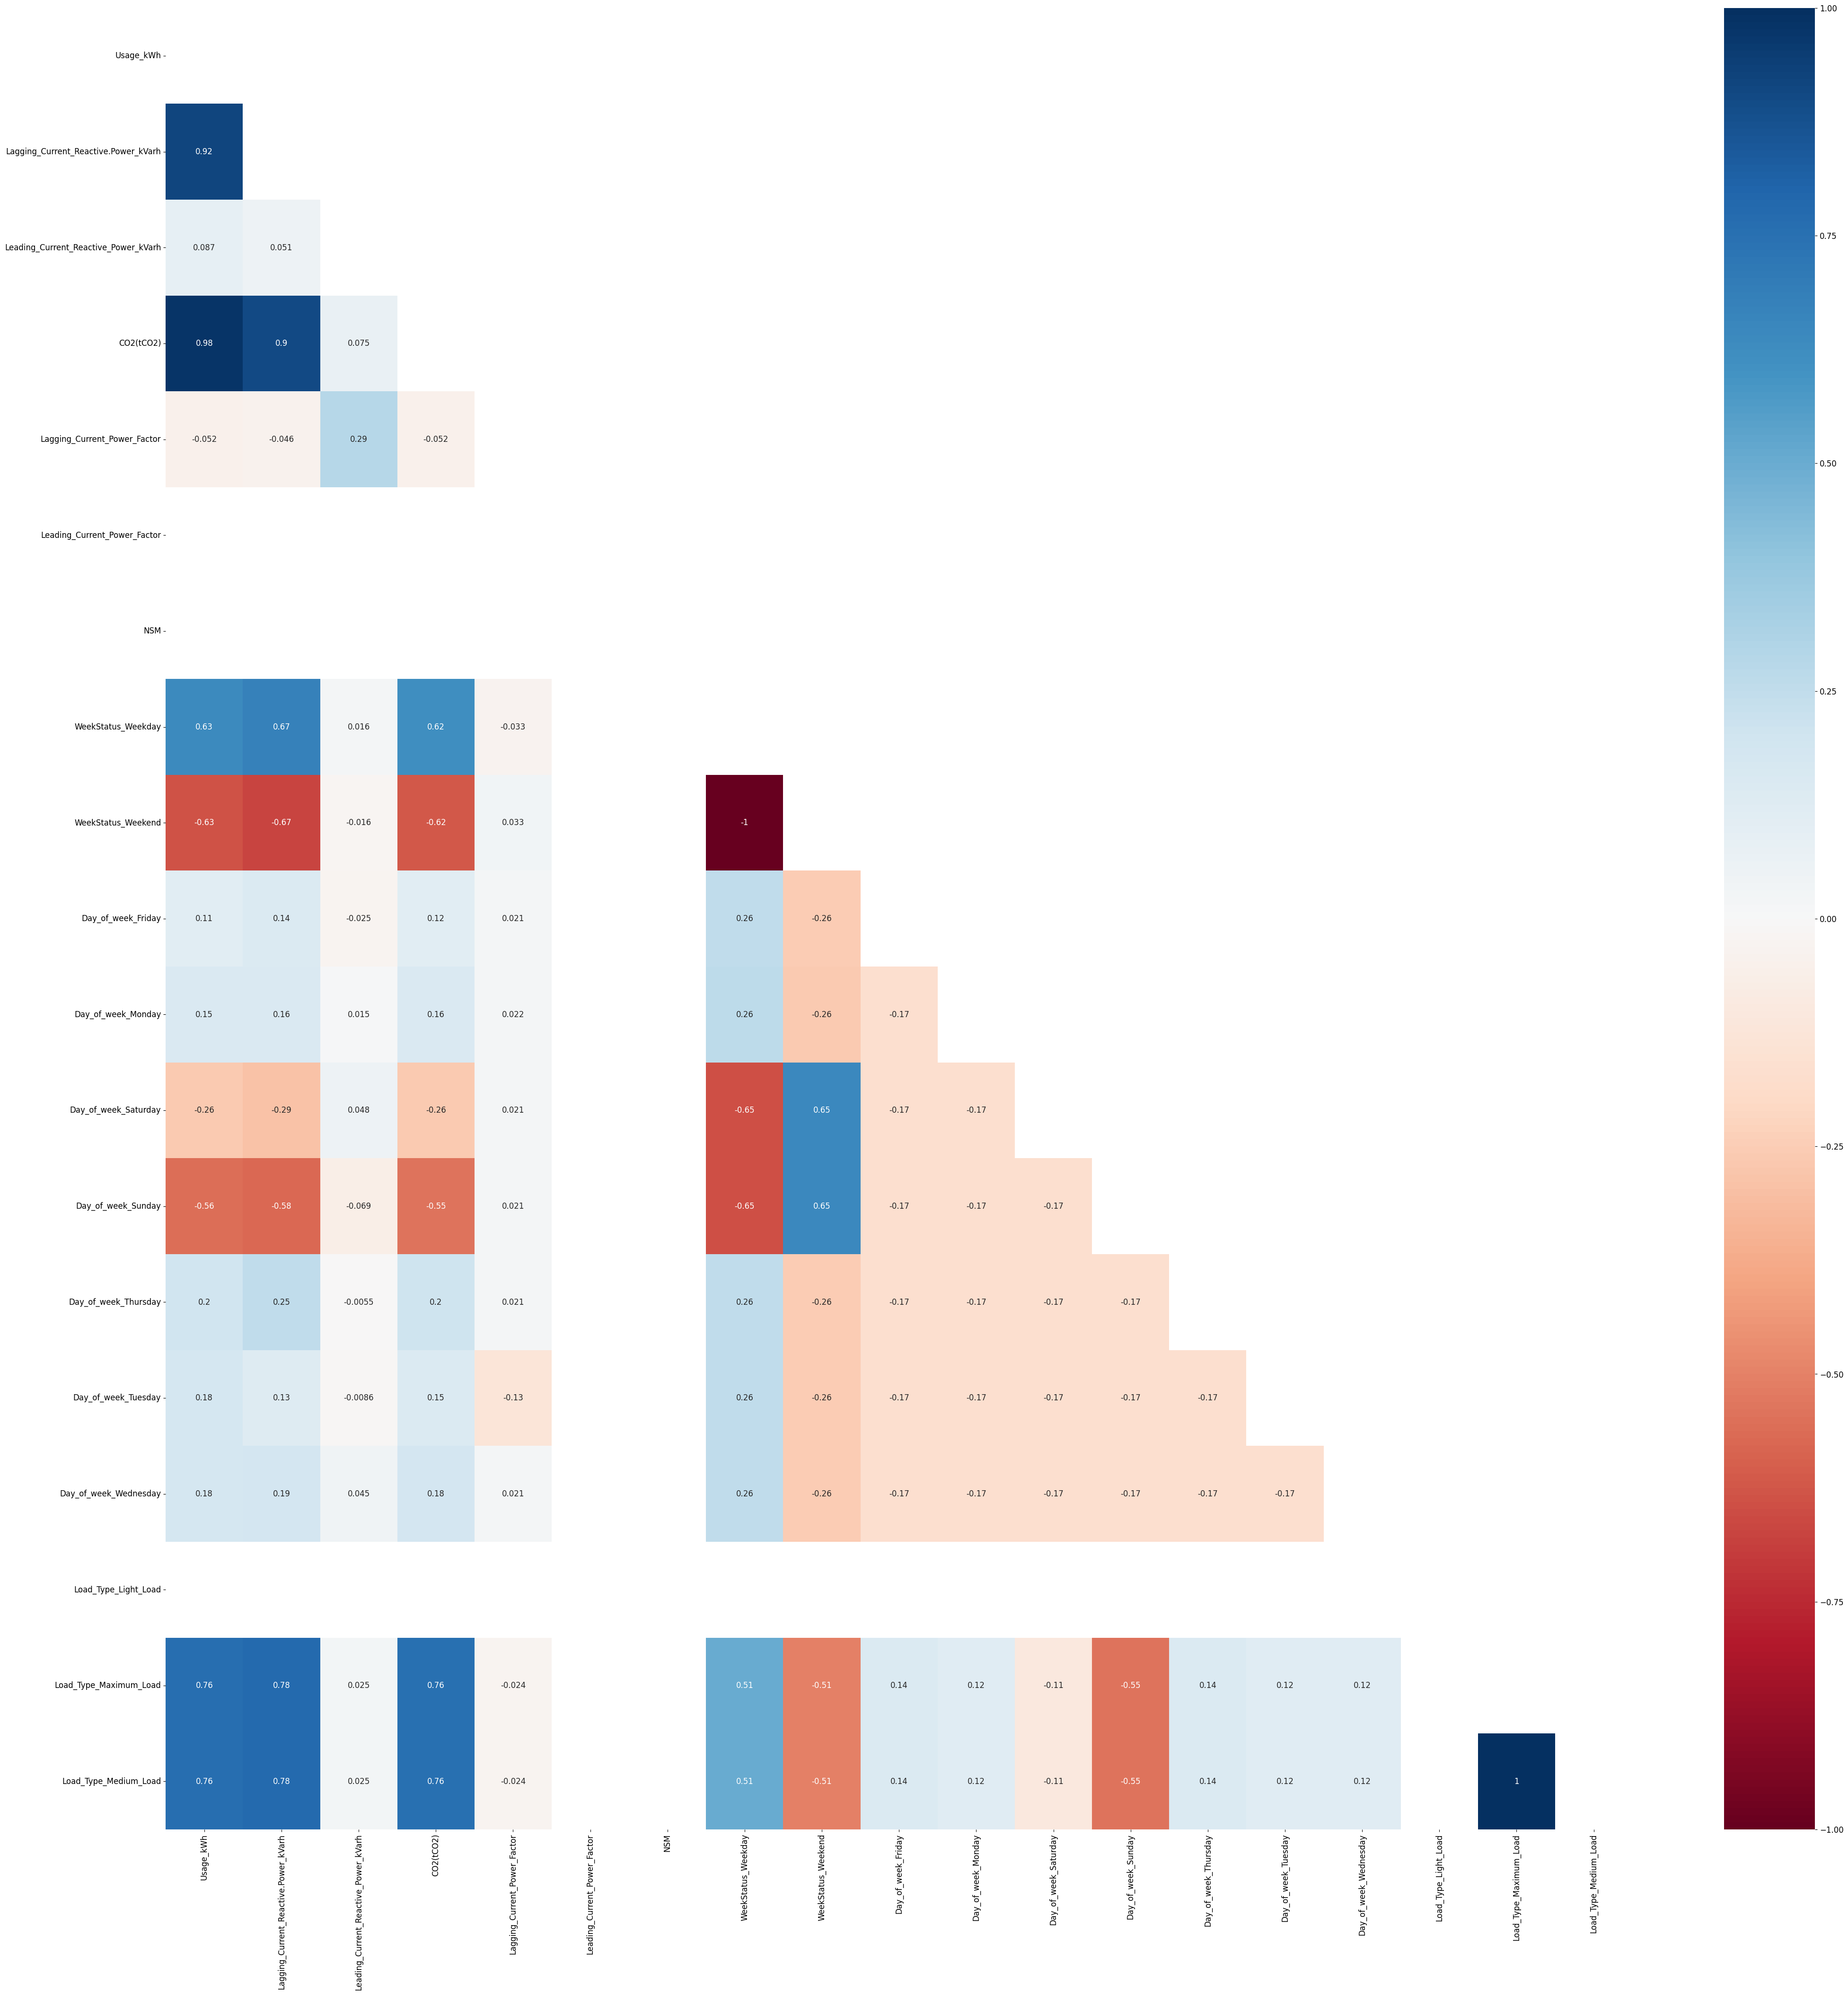

In [39]:
# Select only the numeric columns before calculating correlations
numeric_df = dfnew_max.select_dtypes(include=['number'])
corr = numeric_df.corr()

# plot the correlation matrix and show labels for correlation values
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, annot=True, mask=mask, cmap='RdBu')

# show large plot
plt.rcParams['figure.figsize'] = [50, 50]
plt.show()

In [8]:
# Statistical Testing for Stationary for Maximum
result = adfuller(dfnew_max['Usage_kWh'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.223297
p-value: 0.000602


# ARIMA

In [58]:
# Loop to Evaluate
def evaluate_models_cv(dataset, p_values, d_values, q_values, P_values, D_values, Q_values, m):
    K=5
    result = []
    best_mae, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            trend_order = (p,d,q)
                            seasonal_order = (P,D,Q,m)
                            cfg = [(p,d,q), (P,D,Q,m)]
                            validation_size=31
                            train_size=len(dataset)-validation_size*K
                            mae=0
                            for k in range(0,5):
                                train, test = dataset[0:train_size+k*validation_size],dataset[train_size+k*validation_size:train_size+(k+1)*validation_size]
                                try: # Handle potential convergence issues
                                    model = ARIMA(train, order=trend_order, seasonal_order=seasonal_order)
                                    model_fit = model.fit()  # Suppress convergence warnings
                                    predictions=model_fit.forecast(validation_size)
                                    mae += mean_absolute_error(test, predictions)
                                except LinAlgError:
                                    print(f"ARIMA{cfg} failed to converge.")
                                    mae += float('inf') # Assign a high mae for failed models
                                except ValueError as e: # Catch potential ValueError
                                    print(f"ARIMA{cfg} encountered an error: {e}")
                                    mae += float('inf')
                            mae_avg = mae/5
                            result.append((cfg, mae_avg))
                            if mae_avg < best_mae:
                                best_mae, best_cfg = mae_avg, cfg
                                print('ARIMA%s MAE=%.3f' % (cfg,mae_avg))
    print('Best SARIMA%s MAE=%.3f' % (best_cfg, best_mae))

In [147]:
# order selection
p=[0,1,2]
d=[1,2]
q=[0,1,2]
P=[0,1,2]
D=[1]
Q=[0,1,2]
m=7

In [148]:
# Loop to check
evaluate_models_cv(train.Usage_kWh, p,d,q,P,D,Q,m)

ARIMA[(0, 1, 0), (0, 1, 0, 7)] MAE=66.953
ARIMA[(0, 1, 0), (0, 1, 1, 7)] MAE=30.410
ARIMA[(0, 1, 2), (0, 1, 1, 7)] MAE=29.888
ARIMA[(2, 1, 1), (2, 1, 2, 7)] failed to converge.
ARIMA[(2, 2, 2), (1, 1, 1, 7)] failed to converge.
Best SARIMA[(0, 1, 2), (0, 1, 1, 7)] MAE=29.888


In [61]:
model_sarima = ARIMA(train.Usage_kWh, order=[0, 1, 2], seasonal_order=[0, 1, 1, 7]).fit()
pred_sarima = pd.DataFrame(model_sarima.forecast(len(test.Usage_kWh)))
mean_absolute_error(test.Usage_kWh.values, pred_sarima.values)

34.794711652297664

# SARIMAX

In [185]:
# Function to do CV on SARIMAX
def evaluate_models_sarimax(dataset, p_values, d_values, q_values, trend_values, train_size, exogs):
    K=5
    result = []
    best_mae, best_cfg,best_trend, best_exog = float("inf"), None, None, 'None, use sarima'
    for exog in exogs:
        # Check if exog contains a constant column and adjust trend accordingly
        if np.any(np.all(dataset[exog] == 1, axis=0)):  # Check for constant column
            adjusted_trend_values = [t for t in trend_values if t == 'n']  # Use 'n' (no trend) if constant column exists
        else:
            adjusted_trend_values = trend_values  # Use original trends if no constant column

        for p in p_values:
            for d in d_values:
                for q in q_values:
                    for t in adjusted_trend_values:  # Iterate over adjusted trends
                        if t in ['c', 'ct', 't'] and d > 0 and (d >= p or d >= q):
                            continue
                        if d > 0  and t == 'c':  # If seasonal, just change if to d+D >
                            continue
                        if d > 1 and t == 't':
                            continue
                        if d > 0 and t == 'ct':
                            continue
                        if t == (0,0,1) and d>0:
                            continue
                        if t == (0,1,1) and d>1:
                            continue
                        trend_order = (p,d,q)
                        validation_size = train_size
                        mae = 0
                        for k in range(0,5):
                            train, test = dataset[0:train_size+k*validation_size],dataset[train_size+k*validation_size:train_size+(k+1)*validation_size]
                            model = ARIMA(endog=dataset['Usage_kWh'],
                                            exog=dataset[exog],
                                            order=trend_order, trend = t) #each step: rolling one step forward to update the train se
                            model_fit = model.fit()
                            predictions=model_fit.forecast(validation_size, exog = test[exog])
                            mae += mean_absolute_error(test.Usage_kWh, predictions)
                        mae_avg = mae/5
                        result.append((trend_order, mae_avg))
                        if mae_avg < best_mae:
                            best_mae, best_cfg = mae_avg, trend_order
                            best_trend = t
                            best_exog = exog
                            print('ARIMA%s MAE=%.3f' % (trend_order,mae_avg))
                            print(f'Best Trend: {t}')
                            print(f'Best Exog: {exog}')
    print('Best SARIMAX%s MAE=%.3f' % (best_cfg, best_mae))
    print(f'Best Trend: {best_trend}')
    print(f'Best Exog: {best_exog}')
    return result

In [186]:
# Split into training and testing datasets
dfnm_copy = dfnew_max.reset_index()

# Ensure the 'day' column is of datetime type
dfnm_copy['day'] = pd.to_datetime(dfnm_copy['day'])

# Convert the Timestamp object to a datetime.date object for comparison
train, test = dfnm_copy[dfnm_copy['day'].dt.date <= pd.to_datetime('2018-11-30 23:00:00').date()], dfnm_copy[dfnm_copy['day'].dt.date > pd.to_datetime('2018-11-30 23:00:00').date()]

In [187]:
# order selection
p=[0,1,2]
d=[0,1,2]
q=[0,1,2]
m=7
t = ["ct","c","t","n"]
exogs = ['Lagging_Current_Reactive.Power_kVarh', 'CO2(tCO2)',
         'Day_of_week_Sunday', 'Load_Type_Maximum_Load',
       'Load_Type_Medium_Load'] # Only Significant Columns

In [188]:
evaluate_models_sarimax(train, p,d,q,t,train_size = 30, exogs = exogs)

ARIMA(0, 0, 0) MAE=16.278
Best Trend: ct
Best Exog: Lagging_Current_Reactive.Power_kVarh
ARIMA(0, 0, 0) MAE=15.884
Best Trend: c
Best Exog: Lagging_Current_Reactive.Power_kVarh
ARIMA(0, 0, 1) MAE=15.848
Best Trend: t
Best Exog: Lagging_Current_Reactive.Power_kVarh
ARIMA(0, 0, 2) MAE=15.819
Best Trend: t
Best Exog: Lagging_Current_Reactive.Power_kVarh
ARIMA(1, 0, 0) MAE=15.782
Best Trend: t
Best Exog: Lagging_Current_Reactive.Power_kVarh
ARIMA(2, 0, 0) MAE=15.770
Best Trend: t
Best Exog: Lagging_Current_Reactive.Power_kVarh
ARIMA(0, 0, 0) MAE=4.845
Best Trend: ct
Best Exog: CO2(tCO2)
ARIMA(0, 0, 0) MAE=4.759
Best Trend: t
Best Exog: CO2(tCO2)
ARIMA(2, 0, 2) MAE=4.752
Best Trend: t
Best Exog: CO2(tCO2)
Best SARIMAX(2, 0, 2) MAE=4.752
Best Trend: t
Best Exog: CO2(tCO2)


[((0, 0, 0), 16.27805271797622),
 ((0, 0, 0), 15.884354672611778),
 ((0, 0, 0), 16.013552247017188),
 ((0, 0, 0), 15.88478097628516),
 ((0, 0, 1), 16.34874166092375),
 ((0, 0, 1), 16.11866263754445),
 ((0, 0, 1), 15.847581876482653),
 ((0, 0, 1), 15.927818401384382),
 ((0, 0, 2), 16.334837445868942),
 ((0, 0, 2), 16.11032573274715),
 ((0, 0, 2), 15.818785291969178),
 ((0, 0, 2), 15.925016446545062),
 ((0, 1, 0), 16.87383511042902),
 ((0, 1, 1), 16.812445530713685),
 ((0, 1, 2), 16.756308133085533),
 ((0, 2, 0), 663.0934929668666),
 ((0, 2, 1), 16.867177898598115),
 ((0, 2, 2), 18.680759543602957),
 ((1, 0, 0), 16.291601084798806),
 ((1, 0, 0), 16.097673246334885),
 ((1, 0, 0), 15.781712294106807),
 ((1, 0, 0), 15.919862386437458),
 ((1, 0, 1), 16.317947371195732),
 ((1, 0, 1), 16.66363761999541),
 ((1, 0, 1), 16.506389236524814),
 ((1, 0, 1), 16.455604559720104),
 ((1, 0, 2), 16.32967463299412),
 ((1, 0, 2), 16.636206756116298),
 ((1, 0, 2), 16.49474728493904),
 ((1, 0, 2), 16.41785024

In [189]:
model_sarimax = SARIMAX(train.Usage_kWh, exog = train['CO2(tCO2)'], order=[0, 1, 2], seasonal_order=[0, 1, 1, 7], trend = 'ct').fit()
pred_sarimax = pd.DataFrame(model_sarimax.forecast(len(test.Usage_kWh), exog = test['CO2(tCO2)']))
mean_absolute_error(test.Usage_kWh.values, pred_sarimax.values)

5.754180075736979

# ETS

In [45]:
# Split into train, test sets
train, test = dfnew_max.iloc[:-31], dfnew_max.iloc[-31:]

In [46]:
# trend='add', seasonal= 'add', seasonal_periods = 7, damped_trend = True
model_1 = ExponentialSmoothing(train.Usage_kWh, trend="add", seasonal="add", seasonal_periods=7, damped_trend=True).fit()

# trend='add', seasonal= 'mul', seasonal_periods = 7, damped_trend = True
model_2 = ExponentialSmoothing(train.Usage_kWh, trend="add", seasonal="mul", seasonal_periods=7, damped_trend=True).fit()

# trend='add', seasonal= None, damped_trend = True
model_3 = ExponentialSmoothing(train.Usage_kWh, trend="add", seasonal=None, seasonal_periods=12, damped_trend=True).fit()

# trend='add', seasonal= 'add', seasonal_periods = 7, damped_trend = False
model_4 = ExponentialSmoothing(train.Usage_kWh, trend="add", seasonal="add", seasonal_periods=7, damped_trend=False).fit()

# trend='add', seasonal= 'mul', seasonal_periods = 7, damped_trend = False
model_5 = ExponentialSmoothing(train.Usage_kWh, trend="add", seasonal="mul", seasonal_periods=7, damped_trend=False).fit()

# trend='add', seasonal= None, damped_trend = False
model_6 = ExponentialSmoothing(train.Usage_kWh, trend="add", seasonal=None, seasonal_periods=7, damped_trend=False).fit()


In [47]:
# Get predictions for each of the models
pred_1 = pd.DataFrame(model_1.forecast(len(test.Usage_kWh)))
pred_2 = pd.DataFrame(model_2.forecast(len(test.Usage_kWh)))
pred_3 = pd.DataFrame(model_3.forecast(len(test.Usage_kWh)))
pred_4 = pd.DataFrame(model_4.forecast(len(test.Usage_kWh)))
pred_5 = pd.DataFrame(model_5.forecast(len(test.Usage_kWh)))
pred_6 = pd.DataFrame(model_6.forecast(len(test.Usage_kWh)))

In [48]:
# Loop over each of the models and get their MAEs
preds = [pred_1, pred_2, pred_3, pred_4, pred_5, pred_6]
pred_type = ["trend='add', seasonal= 'add', seasonal_periods = 7, damped_trend = True",
             "trend='add', seasonal= 'mul', seasonal_periods = 7, damped_trend = True",
             "trend='add', seasonal= None, damped_trend = True",
             "trend='add', seasonal= 'add', seasonal_periods = 7, damped_trend = False",
             "trend='add', seasonal= 'mul', seasonal_periods = 7, damped_trend = False",
             "trend='add', seasonal= None, damped_trend = True"]

for i, pred in enumerate(preds):
    print(i+1)
    mae = mean_absolute_error(test.Usage_kWh.values, pred.values)
    print(f'ETS({pred_type[i]}) MAE {mae}\n')

1
ETS(trend='add', seasonal= 'add', seasonal_periods = 7, damped_trend = True) MAE 32.5932300657185

2
ETS(trend='add', seasonal= 'mul', seasonal_periods = 7, damped_trend = True) MAE 35.36430510426918

3
ETS(trend='add', seasonal= None, damped_trend = True) MAE 45.16106410307894

4
ETS(trend='add', seasonal= 'add', seasonal_periods = 7, damped_trend = False) MAE 32.35056855206146

5
ETS(trend='add', seasonal= 'mul', seasonal_periods = 7, damped_trend = False) MAE 35.90566057060863

6
ETS(trend='add', seasonal= None, damped_trend = True) MAE 46.056746763382556



# Theta

In [50]:
# Fitting and Getting predictions of theta model
model_theta_1 = ThetaModel(train.Usage_kWh, period = 7, deseasonalize = True).fit()
model_theta_2 = ThetaModel(train.Usage_kWh, deseasonalize = False).fit()
pred_theta_1 = model_theta_1.forecast(len(test.Usage_kWh))
pred_theta_2 = model_theta_2.forecast(len(test.Usage_kWh))

In [51]:
print(f'Test MAE period = 7, deseasonalize = True: {mean_absolute_error(test.Usage_kWh, pred_theta_1)}')
print(f'Test MAE deseasonalize = False: {mean_absolute_error(test.Usage_kWh, pred_theta_2)}')

Test MAE period = 7, deseasonalize = True: 32.86049573490214
Test MAE deseasonalize = False: 43.237503927396


# Prophet

In [52]:
# Set Train and Test Datasets
trainin = train.copy().reset_index()
testin = test.copy().reset_index()

trainin['ds'] = trainin['day']
trainin['y'] = trainin['Usage_kWh']
trainin = trainin.drop(['Usage_kWh', 'day'], axis = 1)

testin['ds'] = testin['day']
testin['y'] = testin['Usage_kWh']
testin = testin.drop(['Usage_kWh', 'day'], axis = 1)

In [142]:
#Prophet project
m = Prophet(yearly_seasonality = False, weekly_seasonality = True, daily_seasonality=False)
m.add_country_holidays(country_name='KR') # Add Korean Holidays

In [143]:
#Fit with default settings
m.fit(trainin)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp0_cn8bx1/i4cv7woo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0_cn8bx1/8_7khu_w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65554', 'data', 'file=/tmp/tmp0_cn8bx1/i4cv7woo.json', 'init=/tmp/tmp0_cn8bx1/8_7khu_w.json', 'output', 'file=/tmp/tmp0_cn8bx1/prophet_modelphwl5grk/prophet_model-20240621053845.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:38:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:38:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [144]:
#Dataframe with forecasting steps
future = m.make_future_dataframe(periods=len(testin)+1, freq = 'D')
#Forecast
forecast = m.predict(future)

In [145]:
mean_absolute_error(forecast['yhat'].tail().values, testin['y'].tail().values)

27.76924413602929

In [146]:
m.train_holiday_names

0                             New Year's Day
1                            Korean New Year
2          The day preceding Korean New Year
3          The second day of Korean New Year
4                  Independence Movement Day
5                          Buddha's Birthday
6                             Children's Day
7                               Memorial Day
8                             Liberation Day
9                    National Foundation Day
10                                Hangul Day
11                                   Chuseok
12                 The day preceding Chuseok
13                 The second day of Chuseok
14                             Christmas Day
15                        Local Election Day
16    Alternative holiday for Children's Day
17           Alternative holiday for Chuseok
dtype: object

## Prophet CV

In [70]:
# Function to evaluate Prophet models using MAE
def evaluate_models_prophet(dataset, seasonalities_yearly, seasonalities_weekly, seasonalities_daily, changepoint_priors, seasonality_priors, holiday, train_size):
    K = 5
    results = []
    best_mae, best_params = float("inf"), None

    for seasonality in seasonalities_yearly:
      for seasonality_2 in seasonalities_weekly:
          for seasonality_3 in seasonalities_daily:
            for changepoint_prior in changepoint_priors:
                for seasonality_prior in seasonality_priors:
                    mae = 0
                    for k in range(K):
                        train_end = train_size + k * (len(dataset) - train_size) // K
                        if train_end >= len(dataset):
                            continue  # Skip if train_end is beyond dataset length
                        train = dataset[:train_end]
                        test = dataset[train_end:train_end + (len(dataset) - train_size) // K]
                        if len(test) == 0:
                            continue  # Skip if test set is empty

                        model = Prophet(
                            yearly_seasonality=seasonality,
                            weekly_seasonality=seasonality_2,
                            daily_seasonality=seasonality_3,
                            changepoint_prior_scale=changepoint_prior,
                            seasonality_prior_scale=seasonality_prior
                        )
                        if holiday:
                            model.add_country_holidays(country_name='KR')
                        model.fit(train)
                        forecast = model.predict(test)
                        mae += mean_absolute_error(test['y'], forecast['yhat'])

                    mae_avg = mae / K
                    results.append(((seasonality, changepoint_prior, seasonality_prior), mae_avg))
                    if mae_avg < best_mae:
                        best_mae, best_params = mae_avg, (seasonality, changepoint_prior, seasonality_prior)
                        print('Prophet MAE=%.3f for params: %s' % (mae_avg, (seasonality, changepoint_prior, seasonality_prior)))

    print('Best Prophet MAE=%.3f for params: %s' % (best_mae, best_params))
    return results # The function was trying to return two values, changed to return only the results list

In [71]:
# Create copy of datasets
dataset = train.copy()

dataset['ds'] = train.reset_index()['day']
dataset['y'] = train.reset_index()['Usage_kWh']

# Define parameter ranges
seasonalities_yearly = [True, False]
seasonalities_monthly = [True, False]
seasonalities_weekly = [True, False]
changepoint_priors = [0.01, 0.1, 0.5]
seasonality_priors = [1.0, 10.0]
holiday = [True, False]


# Evaluate models
# Evaluate models
results = evaluate_models_prophet(dataset, seasonalities_yearly,
                                               seasonalities_monthly, seasonalities_weekly,
                                               changepoint_priors, seasonality_priors,
                                               holiday, len(trainin)) # Changed to expect a single return value

Prophet MAE=0.000 for params: (True, 0.01, 1.0)
Best Prophet MAE=0.000 for params: (True, 0.01, 1.0)


# AutoTS

In [35]:
# Create Auto-TS dataframe
df_autoTS = pd.DataFrame({"Date": train.index, "Usage_kWh": train["Usage_kWh"]})

# Define validation size
val_size = 31

In [36]:
# List of models and their weightings
model_list = [
    'LastValueNaive',
    'GLS',
    'ETS',
    'AverageValueNaive',
    "ARIMA",
    "GluonTS",
    "SeasonalNaive",
    "FBProphet",
    "Theta"
]

metric_weighting = {
    'smape_weighting': 0,
    'mae_weighting': 0,
    'rmse_weighting': 1,
    'made_weighting': 0,
    'mage_weighting': 0,
    'mle_weighting': 0,
    'imle_weighting': 0,
    'spl_weighting': 0,
    'containment_weighting': 0,
    'contour_weighting': 0,
    'runtime_weighting': 0,
}

In [79]:
# Use AutoTS to fit the model
model = AutoTS(
    forecast_length=val_size,
    frequency='infer',  # Works
    prediction_interval=0.95,
    ensemble=["horizontal", "stack", "simple", "distance", "mosaic"],  # "simple", "distance", "avg", "stack", horizontal
    model_list=model_list,  # "superfast", "default", "fast_parallel"
    transformer_list="fast",  # "superfast",
    drop_most_recent=0,
    max_generations=4,
    num_validations=5,
    validation_method="backwards",
    metric_weighting=metric_weighting
)

model = model.fit(
    df_autoTS,
    date_col='Date',
    value_col='Usage_kWh',
    id_col=None,
)

Using 1 cpus for n_jobs.
Data frequency is: D, used frequency is: D
Model Number: 1 with model ARIMA in generation 0 of 4
Model Number: 2 with model AverageValueNaive in generation 0 of 4
Model Number: 3 with model AverageValueNaive in generation 0 of 4
Model Number: 4 with model AverageValueNaive in generation 0 of 4
Model Number: 5 with model ETS in generation 0 of 4
Model Number: 6 with model ETS in generation 0 of 4
Model Number: 7 with model GLS in generation 0 of 4
Model Number: 8 with model GLS in generation 0 of 4
Model Number: 9 with model GluonTS in generation 0 of 4
Template Eval Error: ImportError('GluonTS installation is incompatible with AutoTS. The numpy version is sometimes the issue, try 1.23.1 {as of 06-2023}') in model 9 in generation 0: GluonTS
Model Number: 10 with model GluonTS in generation 0 of 4
Template Eval Error: ImportError('GluonTS installation is incompatible with AutoTS. The numpy version is sometimes the issue, try 1.23.1 {as of 06-2023}') in model 10 i

In [80]:
prediction = model.predict() # generate predictions

In [81]:
print(prediction.forecast["Usage_kWh"].values)

[ 43.2155762   30.99716659  88.26       102.26       134.25285714
 126.59590713 104.86463449  62.94884015  54.43       107.595
  99.07696258 111.17046231 115.27337787 129.12721436  78.60861522
  53.8        112.96460066 111.03641656 116.31560504 113.51083678
 110.26        64.          43.34148896 136.22019405 122.65122349
 103.         128.06265881 110.26        73.17369364  43.52996357
 148.20194929]


In [82]:
# Check RMSE
np.sqrt(skmetrics.mean_squared_error(prediction.forecast["Usage_kWh"].values, test["Usage_kWh"].values))

48.54358225305278

# Visualization of Our Best Models

In [237]:
# Fitting and Getting Predictions of the models
## ETS
model_ets = ExponentialSmoothing(dfnew_max.Usage_kWh, trend="add", seasonal="add", seasonal_periods=7, damped_trend=False).fit()
pred_ets = pd.DataFrame(model_1.forecast(len(test.Usage_kWh)))

## Theta
model_theta = ThetaModel(dfnew_max.Usage_kWh, period = 7, deseasonalize = True).fit()
pred_theta = model_theta.forecast(len(test.Usage_kWh))

## Prophet
df_prophet = dfnew_max.copy()
df_prophet['ds'] = df_prophet.index
df_prophet['y'] = df_prophet.Usage_kWh
m = Prophet()
m.add_country_holidays(country_name='KR')
m.fit(trainin)
future = m.make_future_dataframe(periods=2*len(testin), freq = 'D')
forecast = m.predict(future)

# ARIMA
model_arima = ARIMA(dfnew_max.Usage_kWh, order=[0, 1, 2], seasonal_order=[0, 1, 1, 7]).fit()
pred_arima = pd.DataFrame(model_arima.forecast(len(test.Usage_kWh)))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0_cn8bx1/yk70zqa9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0_cn8bx1/d8boosqb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10554', 'data', 'file=/tmp/tmp0_cn8bx1/yk70zqa9.json', 'init=/tmp/tmp0_cn8bx1/d8boosqb.json', 'output', 'file=/tmp/tmp0_cn8bx1/prophet_model_101oah3/prophet_model-20240621074605.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:46:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:46:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


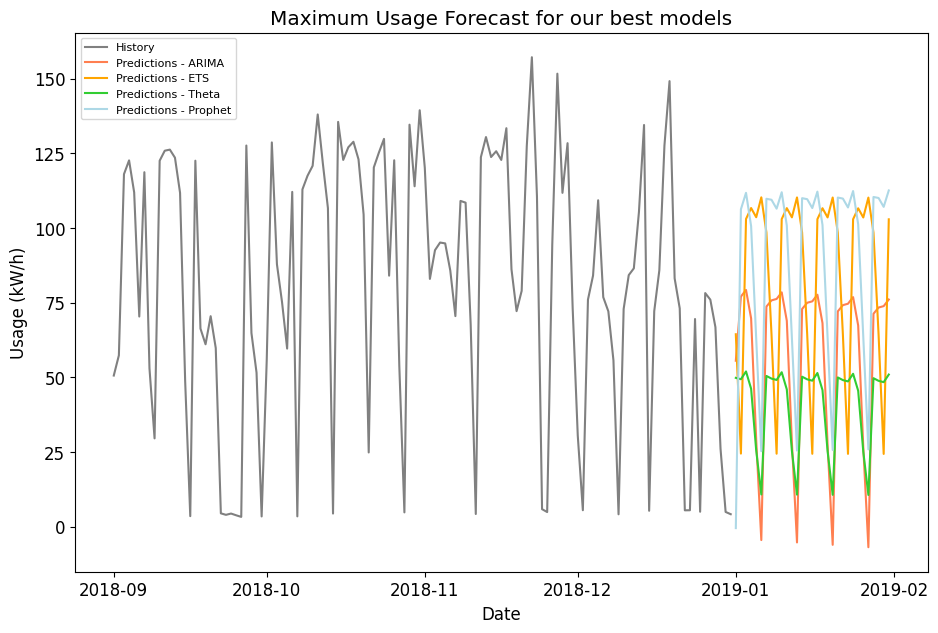

In [238]:
# Generate the next 30 days
next_month = pd.date_range(start=dfnew_max.index[-1] + pd.Timedelta(days=1), periods=31)
next_month

# Plot the projections with history on a plot
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(11, 7))

# Ensure the DataFrame index is in datetime format
dfnew_max.index = pd.to_datetime(dfnew_max.index)

# Define the start date for slicing
start_date = pd.to_datetime('2018-09-01')

# Plot the data from the start_date onwards
try:
    ax.plot(dfnew_max.loc[start_date:, 'Usage_kWh'], label='History', color='grey')
except KeyError as e:
    print(f"KeyError: {e}")
    print("Please check if the DataFrame index and the start_date are correctly formatted.")
plt.plot(next_month, pred_arima, label='Predictions - ARIMA', color = 'coral')
plt.plot(next_month, pred_ets, label='Predictions - ETS', color = 'orange')
plt.plot(next_month, pred_theta, label='Predictions - Theta', color = 'limegreen')
plt.plot(next_month, forecast['yhat'].tail(31), label='Predictions - Prophet', color = 'lightblue')
plt.legend(loc='upper left', fontsize=8)
ax.set_title('Maximum Usage Forecast for our best models')
ax.set_xlabel('Date')
ax.set_ylabel('Usage (kW/h)')
plt.show()

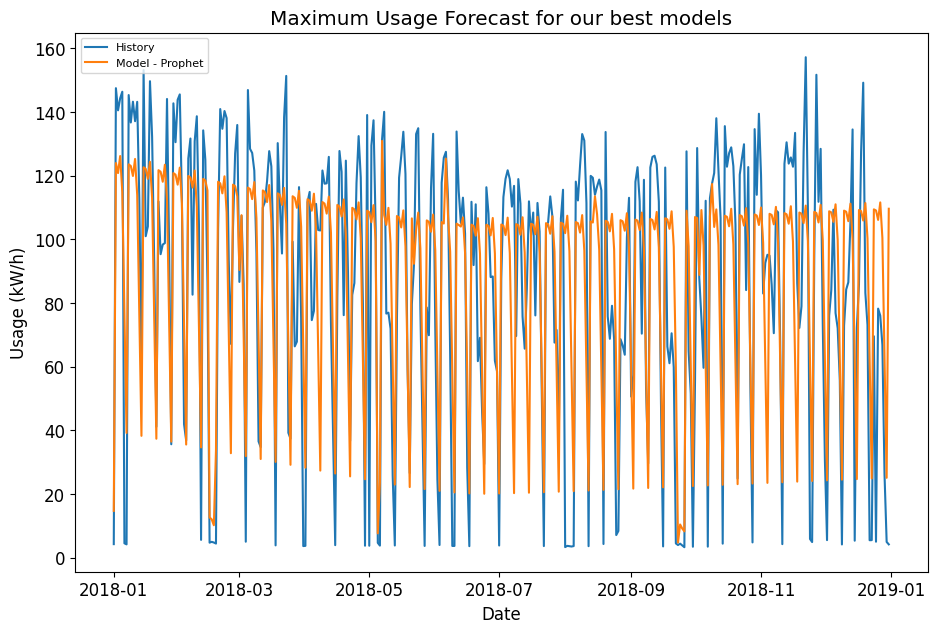

In [229]:
# SARIMAX Best Model
fig, ax = plt.subplots(figsize=(11, 7))

ax.plot(dfnew_max.Usage_kWh, label='History')
plt.plot(dfnew_max.index, forecast[:365].yhat, label='Model - Prophet')
plt.legend(loc='upper left', fontsize=8)
ax.set_title('Maximum Usage Forecast for our best models')
ax.set_xlabel('Date')
ax.set_ylabel('Usage (kW/h)')
plt.show()

# Best Model: SARIMAX

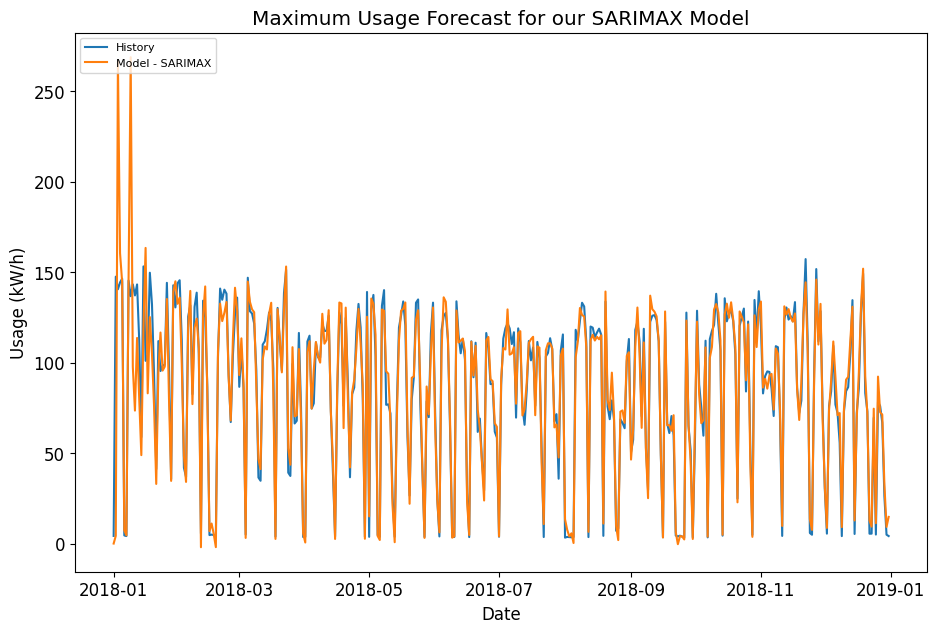

In [222]:
fig, ax = plt.subplots(figsize=(11, 7))

ax.plot(dfnew_max.Usage_kWh, label='History')
plt.plot(dfnew_max.index, pd.concat([model_sarimax.fittedvalues, model_sarimax.forecast(len(test.Usage_kWh), exog = test['CO2(tCO2)'])]), label='Model - SARIMAX')
plt.legend(loc='upper left', fontsize=8)
ax.set_title('Maximum Usage Forecast for our SARIMAX Model')
ax.set_xlabel('Date')
ax.set_ylabel('Usage (kW/h)')
plt.show()

# Model to Predict CO2

In [230]:
# Loop to check
evaluate_models_cv(train['CO2(tCO2)'], p,d,q,P,D,Q,m)

ARIMA[(0, 0, 0), (0, 1, 0, 7)] MAE=0.019
ARIMA[(0, 0, 0), (0, 1, 1, 7)] MAE=0.014
ARIMA[(0, 0, 1), (0, 1, 1, 7)] MAE=0.014
ARIMA[(0, 0, 2), (0, 1, 1, 7)] MAE=0.014
ARIMA[(0, 0, 2), (1, 1, 2, 7)] MAE=0.013
ARIMA[(1, 0, 2), (0, 1, 1, 7)] MAE=0.013
ARIMA[(1, 0, 2), (1, 1, 2, 7)] MAE=0.013
ARIMA[(2, 0, 1), (0, 1, 1, 7)] MAE=0.013
Best SARIMA[(2, 0, 1), (0, 1, 1, 7)] MAE=0.013


In [242]:
model_arima_co2 = ARIMA(train['CO2(tCO2)'], order=[2, 0, 1], seasonal_order=[0, 1, 1, 7]).fit()
pred_sarima_co2 = pd.DataFrame(model_arima_co2.forecast(len(test['CO2(tCO2)'])))
mean_absolute_error(test['CO2(tCO2)'].values, pred_sarima_co2.values)

0.01504824114676396

In [243]:
model_arima_co2_v2 = ARIMA(dfnew_max['CO2(tCO2)'], order=[2, 0, 1], seasonal_order=[0, 1, 1, 7]).fit()
pred_sarima_co2_next_month = pd.DataFrame(model_arima_co2_v2.forecast(31))

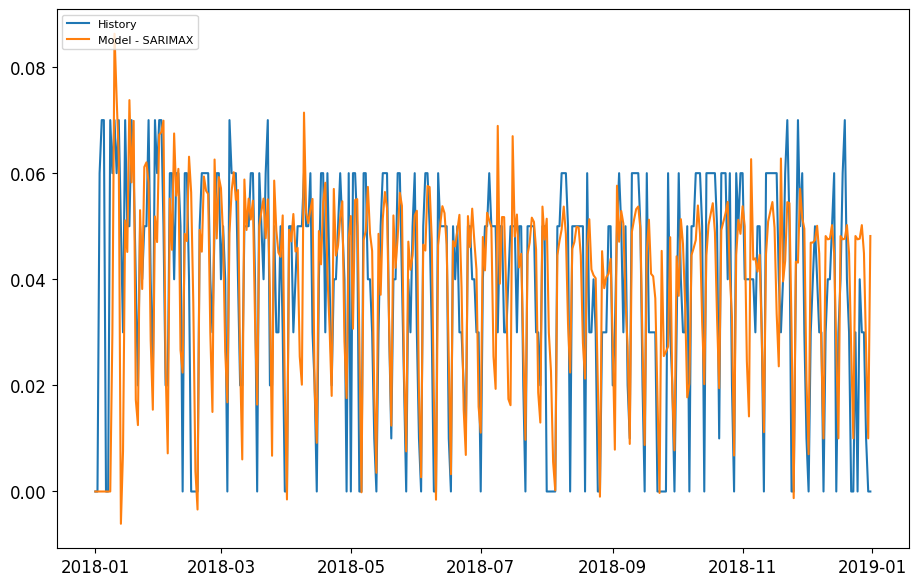

In [258]:
fig, ax = plt.subplots(figsize=(11, 7))

ax.plot(dfnew_max['CO2(tCO2)'], label='History')
plt.plot(dfnew_max.index, pd.concat([model_arima_co2.fittedvalues, model_arima_co2.forecast(len(test['CO2(tCO2)']))]), label='Model - SARIMAX')
plt.legend(loc='upper left', fontsize=8)

# Model with Predictions

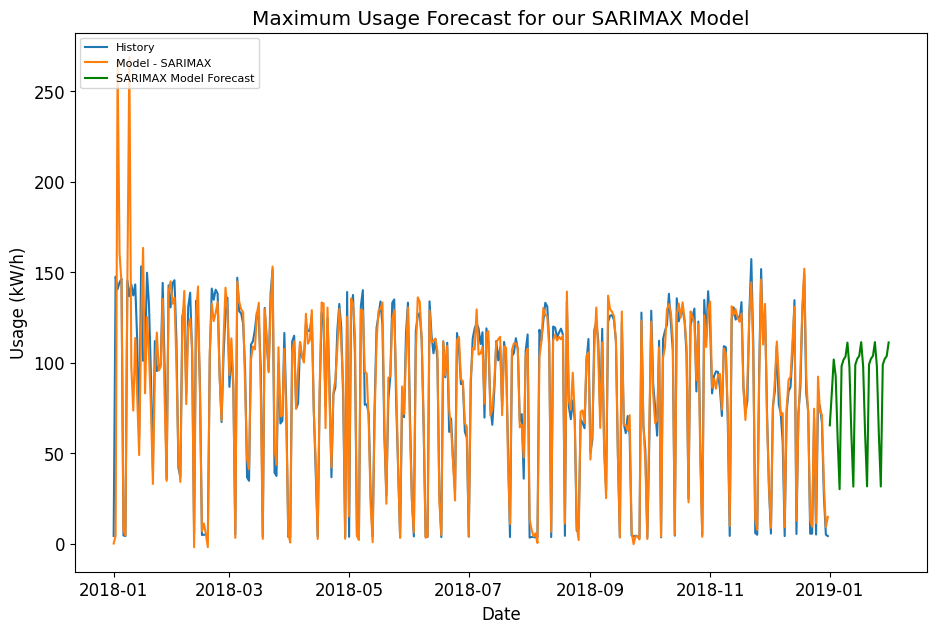

In [246]:
fig, ax = plt.subplots(figsize=(11, 7))

ax.plot(dfnew_max.Usage_kWh, label='History')
plt.plot(dfnew_max.index, pd.concat([model_sarimax.fittedvalues, model_sarimax.forecast(len(test.Usage_kWh), exog = test['CO2(tCO2)'])]), label='Model - SARIMAX')
plt.plot(next_month, model_sarimax.forecast(31, exog = pred_sarima_co2_next_month), label = 'SARIMAX Model Forecast', color = 'green')
plt.legend(loc='upper left', fontsize=8)
ax.set_title('Maximum Usage Forecast for our SARIMAX Model')
ax.set_xlabel('Date')
ax.set_ylabel('Usage (kW/h)')
plt.show()

In [265]:
# Save predictions as .csv file
pd.DataFrame({'Predictions': model_sarimax.forecast(31, exog = pred_sarima_co2_next_month).values}, index=next_month).to_csv('predictions.csv')